In [392]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from keras import Input, Model, regularizers
from keras.datasets import mnist
from keras.layers import Dense
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from tensorflow.keras.losses import categorical_crossentropy, mean_squared_error
from tensorflow.keras.optimizers import Adam
import sys

In [393]:
#System to solve :
#given q0 and p0 and model parameters k,m #  solve (dq/dt = p/m ; dp/dt = -kq)
# this script generates data points

In [441]:

class oscillator():
    def __init__(self, **kwargs):
        self.m = kwargs.get("m",1.)
        self.k = kwargs.get("k",1.)
        self.omega0 = (self.k/self.m)**0.5
    def compute_hamiltonian(self, trajectory):
        hamiltonian =  trajectory[0,:]**2*self.k +trajectory[1,:]**2/self.m
        hamiltonian *= 0.5
        return hamiltonian
    def compute_hamiltonian_derivative(self,t,x):
        f0 = x[1]/self.m
        f1 = -self.k*x[0]
        res = np.array([f0,f1])
        return res
    def simulate(self, x0, dt, n_steps, method = "RK45"):
        tspan = np.arange(n_steps)*dt
        sim_result = scipy.integrate.solve_ivp(fun = self.compute_hamiltonian_derivative, method= method, 
                                              y0=x0, t_span = [tspan.min(),tspan.max()], t_eval= tspan, vectorized=True)
        self.orbit = sim_result.y
        self.t = tspan
        self.exact_solution = sim_result.y*0
        A = x0[0]; B = x0[1]/(self.k)
        self.exact_solution[0,:] = A*np.cos(self.omega0*self.t)+B*np.sin(self.omega0*self.t)
        self.exact_solution[1,:] = (-A*np.sin(self.omega0*self.t)+B*np.cos(self.omega0*self.t))*self.omega0


In [442]:
kwargs = {}
kwargs["m"]=1
kwargs["k"] = 2
osc = oscillator(**kwargs) 

In [447]:
n_sims = 100
x0 = np.random.randn(n_sims*2)*10
x0=np.reshape(x0,(2,n_sims))
nstep =10000
dt = (2*np.pi/osc.omega0)/(nstep+1)
for i in tqdm(range(n_sims)):
    n_step = int(2*np.pi/osc.omega0/dt)+1
    osc.simulate(x0[:,i], dt=dt, n_steps=nstep, method = "RK45") #, method = "DOP853")
    integrated_energy = osc.compute_hamiltonian(osc.orbit)
    exact_energy =  osc.compute_hamiltonian(osc.exact_solution)
    if(i==0):
        trajectories = osc.orbit.T
        energies = integrated_energy*1
    else:
        trajectories = np.concatenate((trajectories,osc.orbit.T))
        energies = np.concatenate((energies,integrated_energy))


<IPython.core.display.Javascript object>


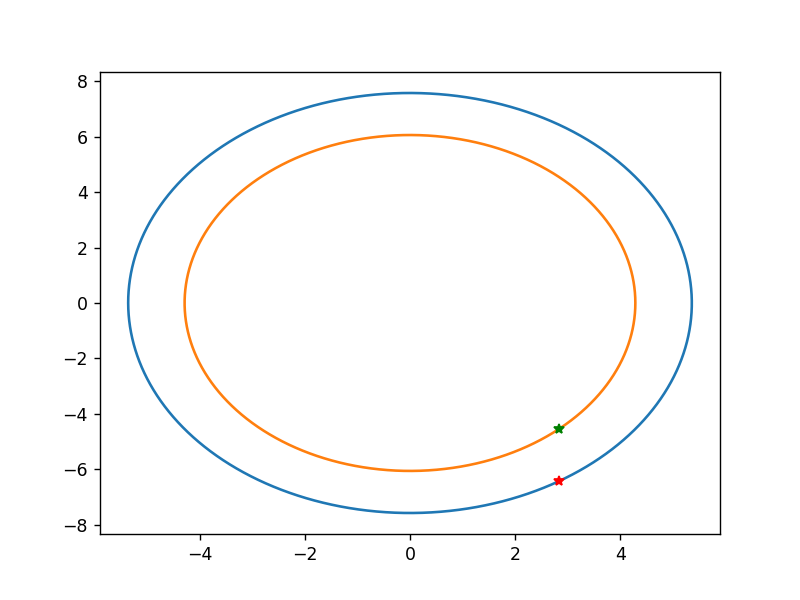

In [448]:
plt.figure()
plt.plot(osc.orbit[0,:], osc.orbit[1,:])
plt.plot(osc.exact_solution[0,:], osc.exact_solution[1,:])
plt.plot( osc.orbit[0,0], osc.orbit[1,0] , "r*")
plt.plot( osc.exact_solution[0,0], osc.exact_solution[1,0] , "g*")

In [449]:
def square_activation(x):
    return K.pow(x,2)

get_custom_objects().update({'square_activation': Activation(square_activation)})

def power_four_activation(x):
    return K.pow(x,4)

get_custom_objects().update({'power_four_activation': Activation(power_four_activation)})

In [450]:
input_data = Input(shape=(2,))
new_layer = Dense(70, activation=square_activation)(input_data)
new_layer = Dense(40, activation='softplus')(new_layer)
new_layer = Dense(1, activation='softplus')(new_layer)
model = Model(input_data, new_layer)
#loss = model(input_data)
model.compile(optimizer='adam', loss='mean_absolute_error')


In [451]:
x_train = trajectories
y_train = energies[:,None]

In [415]:
history = model.fit(x_train, y_train,
                epochs=10,
                batch_size=1000,
                shuffle=True)

Epoch 1/25
1000/1000 [==============================] - 2s 2ms/step - loss: 5.3740
Epoch 2/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3446
Epoch 3/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2902
Epoch 4/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3337
Epoch 5/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3113
Epoch 6/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3101
Epoch 7/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2858
Epoch 8/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3126
Epoch 9/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3162
Epoch 10/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2904
Epoch 11/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3126
Epoch 12/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3100
E

In [372]:
x_test = np.random.randn(100*2)*100+50
x_test =np.reshape(x_test,(100,2))
energy_test  = x_test[:,0]**2*osc.k*0.5 + x_test[:,1]**2/osc.m*0.5
y_pred = model.predict(x_test,batch_size=1000)

In [472]:
x_train = x_train
y_train = 0*x_train
y_train[:,0] = x_train[:,0]*osc.k
y_train[:,1] = (1/osc.m)*x_train[:,1]


In [473]:
input_data = Input(shape=(2,))
new_layer = Dense(70, activation=square_activation)(input_data)
new_layer = Dense(40, activation='softplus')(new_layer)
new_layer = Dense(1, activation='softplus')(new_layer)
model = Model(input_data, new_layer)
opt = Adam()

def step(X, y):
    x = tf.Variable(X,dtype="float32")

    with tf.GradientTape() as tape2:
        with tf.GradientTape() as tape1:
            H = model(x)
        dH = tape1.gradient(H, x)
        loss = mean_squared_error(dH,y)
    grads = tape2.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))

In [474]:
EPOCHS = 3
BS = 1000
numUpdates = int(x_train.shape[0] / BS)
model.compile(optimizer=opt, loss=mean_squared_error,metrics=["acc"])

for epoch in range(0, EPOCHS):
    # show the current epoch number
    print("[INFO] starting epoch {}/{}...".format(
        epoch + 1, EPOCHS), end="")
    sys.stdout.flush()
    epochStart = time.time()
    for i in tqdm(range(0, numUpdates)):
        # determine starting and ending slice indexes for the current
        # batch
       
        start = i * BS
        end = start + BS
        step(x_train[start:end], y_train[start:end])

[INFO] starting epoch 1/3...


[INFO] starting epoch 2/3...


[INFO] starting epoch 3/3...

In [475]:
model.compile(optimizer=opt, loss=mean_squared_error,metrics=["acc"])
(loss, acc) = model.evaluate(x_train[:2000,:], y_train[:2000,:])

63/63 [==============================] - 0s 775us/step - loss: 10651.8818 - acc: 0.0000e+00


<IPython.core.display.Javascript object>


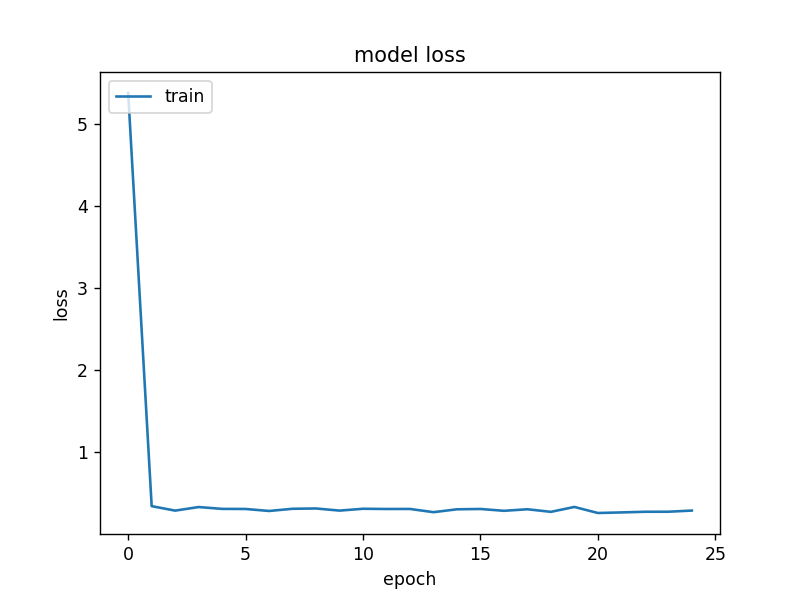

In [423]:
plt.figure()
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')